In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('../../src'))
print("adding following folder to path: ",module_path)
if module_path not in sys.path:
    sys.path.append(module_path)

adding following folder to path:  /home/enis/projects/nna/src


In [2]:
import numpy as np 
from numpy import linspace
import pandas as pd


import datetime
from scipy import stats
import time
import copy
from sklearn.preprocessing import minmax_scale
from sklearn.metrics import precision_recall_fscore_support


import csv 
from pathlib import Path
from os import listdir
import pickle

from tabulate import tabulate


from datetime import datetime,timedelta

import itertools


import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt 
import matplotlib.dates as dates
from matplotlib.ticker import NullFormatter
from matplotlib.colors import ListedColormap
from matplotlib import cm

from pytz import timezone




In [4]:
from pre_process_func import read_queue
from fileUtils import read_file_properties
from labeling_utils import load_labels
from visUtils import get_cycle,createTimeIndex,file2TableDict,reverseTableDict

In [5]:
# INPUT_DIR_PARENT = "/home/data/nna/stinchcomb/NUI_DATA/"


In [6]:
linestyle_str = [
     ('solid', 'solid'),      # Same as (0, ()) or '-'
     ('dotted', 'dotted'),    # Same as (0, (1, 1)) or '.'
     ('dashed', 'dashed'),    # Same as '--'
     ('dashdot', 'dashdot'),  # Same as '-.
     ('densely dotted',        (0, (1, 1))),
     ('densely dashed',        (0, (5, 1))),
    ('densely dashdotted',    (0, (3, 1, 1, 1))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))]


In [7]:
dataFlder="/home/enis/projects/nna/data/"
resultsFlder="/home/enis/projects/nna/results/"


In [8]:
id2name={}
id2name["_CABLE"]="Cable"
id2name["_RUNNINGWATER"]="Running Water"
id2name["_INSECT"]="Insect"
id2name["_RAIN"]="Rain"
id2name["_WATERBIRD"]="Water Bird"
id2name["_WIND"]="Wind"
id2name["_SONGBIRD"]="Songbird"
id2name["_AIRCRAFT"]="Aircraft"



In [40]:
# file_properties_df=pd.read_pickle("../../data/stinchcomb_dataV1.pkl")
file_properties_df=pd.read_pickle("../../data/realdata_v2No_stinchcomb.pkl")

#important to keep them in order
file_properties_df.sort_values(by=['timestamp'],inplace=True)

# delete older than 2016
fromtime=datetime(2016, 1, 1, 0)
file_properties_df=file_properties_df[file_properties_df.timestamp>=fromtime]
all_areas=sorted(pd.unique(file_properties_df.site_id.values))

In [10]:
# file_properties_df[file_properties_df.site_id=="47"]

In [341]:
# PARAMS
# FREQS to reduce results 
freq="30min"
freq="2H"


# possible places to pick
# sorted(pd.unique(file_properties_df.site_id.values))
# areas to be visualized



In [258]:

# globalindex,all_start,all_end=createTimeIndex(selected_areas,file_properties_df,freq)

# selected_tag_name="_SONGBIRD"
model_tag_names=["CABLE","RUNNINGWATER","INSECT", "RAIN", "WATERBIRD", "WIND", "SONGBIRD", "AIRCRAFT"]

model_tag_names=["_"+i for i in model_tag_names]
selected_tag_name=model_tag_names[:]

weather_cols=[]
globalcolumns=model_tag_names#selected_areas+weather_cols

visFilePath="/home/enis/projects/nna/results/vis/AreaBasedErrorCheck/"


In [259]:
all_areas[20:21]

['31']

In [260]:
# print(" Duration of selected data period:",(all_end-all_start).days,"days")
# print(" Starts: {} \n Ends:   {}".format(all_start,all_end))

In [39]:
globalindex

DatetimeIndex(['2016-06-03 00:00:00', '2016-06-03 02:00:00',
               '2016-06-03 04:00:00', '2016-06-03 06:00:00',
               '2016-06-03 08:00:00', '2016-06-03 10:00:00',
               '2016-06-03 12:00:00', '2016-06-03 14:00:00',
               '2016-06-03 16:00:00', '2016-06-03 18:00:00',
               ...
               '2016-08-25 02:00:00', '2016-08-25 04:00:00',
               '2016-08-25 06:00:00', '2016-08-25 08:00:00',
               '2016-08-25 10:00:00', '2016-08-25 12:00:00',
               '2016-08-25 14:00:00', '2016-08-25 16:00:00',
               '2016-08-25 18:00:00', '2016-08-25 20:00:00'],
              dtype='datetime64[ns]', length=1007, freq='2H')

In [41]:
file_properties_df[file_properties_df.site_id=="09-USGS"]

,site_id,locationId,site_name,recorderId,hour_min_sec,year,month,day,region,timestamp,durationSec,timestampEnd
/tank/data/nna/real/stinchcomb/09-USGS/2016/USGS_20160603_151612.MP3,09-USGS,09-USGS,,USGS,151612,2016,06,03,stinchcomb,2016-06-03 15:16:12,178870,2016-06-05 16:57:22.256333
/tank/data/nna/real/stinchcomb/09-USGS/2016/USGS_20160605_165727.MP3,09-USGS,09-USGS,,USGS,165727,2016,06,05,stinchcomb,2016-06-05 16:57:27,178869,2016-06-07 18:38:36.237583
/tank/data/nna/real/stinchcomb/09-USGS/2016/USGS_20160607_183841.MP3,09-USGS,09-USGS,,USGS,183841,2016,06,07,stinchcomb,2016-06-07 18:38:41,178869,2016-06-09 20:19:50.263667
/tank/data/nna/real/stinchcomb/09-USGS/2016/USGS_20160609_201955.MP3,09-USGS,09-USGS,,USGS,201955,2016,06,09,stinchcomb,2016-06-09 20:19:55,178869,2016-06-11 22:01:04.237583
/tank/data/nna/real/stinchcomb/09-USGS/2016/USGS_20160611_220109.MP3,09-USGS,09-USGS,,USGS,220109,2016,06,11,stinchcomb,2016-06-11 22:01:09,178869,2016-06-13 23:42:18.263667
/tank/data/nna/real/stinchcomb/09-USGS/2016/USGS_20160613_234225.MP3,09-USGS,09-USGS,,USGS,234225,2016,06,13,stinchcomb,2016-06-13 23:42:25,178869,2016-06-16 01:23:34.237500
/tank/data/nna/real/stinchcomb/09-USGS/2016/USGS_20160616_012339.MP3,09-USGS,09-USGS,,USGS,012339,2016,06,16,stinchcomb,2016-06-16 01:23:39,178869,2016-06-18 03:04:48.237583
/tank/data/nna/real/stinchcomb/09-USGS/2016/USGS_20160618_030453.MP3,09-USGS,09-USGS,,USGS,030453,2016,06,18,stinchcomb,2016-06-18 03:04:53,178869,2016-06-20 04:46:02.263667
/tank/data/nna/real/stinchcomb/09-USGS/2016/USGS_20160620_044609.MP3,09-USGS,09-USGS,,USGS,044609,2016,06,20,stinchcomb,2016-06-20 04:46:09,178869,2016-06-22 06:27:18.237583
/tank/data/nna/real/stinchcomb/09-USGS/2016/USGS_20160622_062723.MP3,09-USGS,09-USGS,,USGS,062723,2016,06,22,stinchcomb,2016-06-22 06:27:23,178869,2016-06-24 08:08:32.263667


In [342]:
%%time
result_path="/scratch/enis/data/nna/real/"

for selected_area in all_areas[20:21]:
    print(selected_area,all_areas.index(selected_area))
    selected_areas=[selected_area,]
    
    regionName=file_properties_df[file_properties_df.site_id==selected_area][:1].region[0]

    globalindex,all_start,all_end=createTimeIndex(selected_areas,file_properties_df,freq)

    df_dict,no_result_paths = file2TableDict(selected_areas,model_tag_names,globalindex,
                                             globalcolumns,file_properties_df,freq,dataFreq="10S",
                                             result_path=result_path,prob2binaryFlag=False)

    print("{} number of files do not have results".format(len(no_result_paths)))

    # df_dict_reverse=reverseTableDict(selected_areas,df_dict,model_tag_names)
    df_count,df_sums=df_dict[selected_area]

    df_freq=df_sums/df_count
    # del df_freq['UMIAT']

    df_freq=df_freq*100
#     df_freq=df_freq.dropna(how='all')
    # df_freq=pd.concat([df_freq, normal_weather], axis=1, join='inner')


    # cord_list=sorted(list(cord.items()),key=lambda x: x[1][0],reverse=True)

    # cord_list=list(filter(lambda x: x[0] in df_freq.columns ,cord_list))

    cord_list=[(i,(0,0)) for i in df_freq.columns]
    
    monthsTime=pd.unique(df_freq.index.strftime("%Y-%m-01"))
    monthsTime=[pd.Timestamp(i) for i in monthsTime]
    
#     monthsTime=pd.date_range("{}-{}".format(all_start.year,all_start.month),"{}-{}".format(all_end.year,all_end.month), freq='MS',)
    monthsTimeStr=["{}-{}".format(month.year,month.month) for month in monthsTime]
    # months=[df_freq.loc['2019-05':'2019-05'],df_freq.loc['2019-06':'2019-06']]
    months=[df_freq.loc[month:month] for month in monthsTimeStr]
#     months=[month for month in months if month.size>0]
    # months2=[df_freq.loc['2016-06-01':'2016-06-30'],df_freq.loc['2016-07-01':'2016-07-31'],df_freq.loc['2016-08-01':'2016-08-31']]
#     break
    # make them all same month for aligning 
    
#     for i,month in enumerate(months):
#         months[i]=month.rename(index=lambda x: x.replace(month=7,year=2019))

# #     break
#     uniqueYears=np.unique([month.year for month in monthsTime])
#     for year in uniqueYears:
#         monthsInAYear=[months[i] for i,month in enumerate(monthsTime) if month.year==year]
#         monthsTimeInAYear=[monthsTime[i] for i,month in enumerate(monthsTime) if month.year==year]
#         createFigure(monthsInAYear,monthsTimeInAYear)
    


31 20
0 number of files do not have results
CPU times: user 1min 7s, sys: 1.26 s, total: 1min 8s
Wall time: 1min 16s


In [262]:
# df_count._SONGBIRD

In [263]:
len(a[a>540])/len(a)

0.20833333333333334

In [264]:
aa=df_count._SONGBIRD[df_count._SONGBIRD>0]

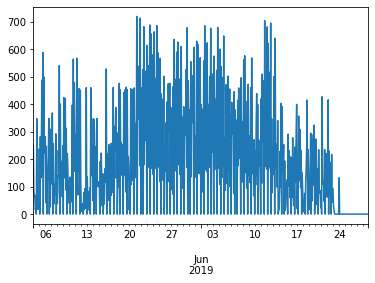

In [393]:
df_sums._SONGBIRD.plot()

In [221]:
a=df_count._SONGBIRD[df_count._SONGBIRD>0]["2019-6-15":"2019-6-22"]
b=df_sums._SONGBIRD[df_sums._SONGBIRD>0]["2019-6-15":"2019-6-22"]
c=df_freq._SONGBIRD[df_freq._SONGBIRD>0]["2019-6-15":"2019-6-22"]

In [340]:
a30min=df_count._SONGBIRD["2019-6-15":"2019-6-22"]
b30min=df_sums._SONGBIRD["2019-6-15":"2019-6-22"]
c30min=df_freq._SONGBIRD["2019-6-15":"2019-6-22"]

In [343]:
a2H=df_count._SONGBIRD["2019-6-15":"2019-6-22"]
b2H=df_sums._SONGBIRD["2019-6-15":"2019-6-22"]
c2H=df_freq._SONGBIRD["2019-6-15":"2019-6-22"]

In [304]:
# df_count.plot()

In [205]:
len(df_count._SONGBIRD),len(df_count._SONGBIRD[df_count._SONGBIRD<1]),len(df_count._SONGBIRD[df_count._SONGBIRD<360])



(671, 156, 285)

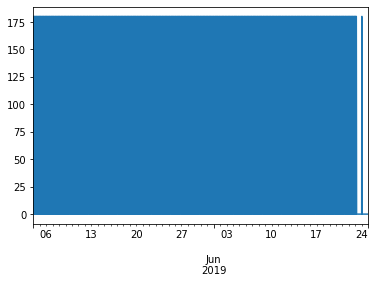

In [266]:
df_count._SONGBIRD.plot()

In [207]:
len(a[a<181])/len(a)

ZeroDivisionError: division by zero

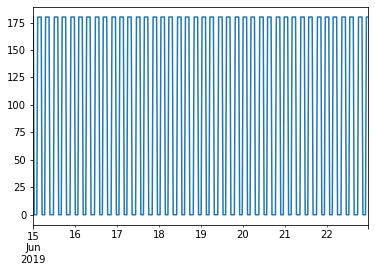

In [267]:
a.plot()


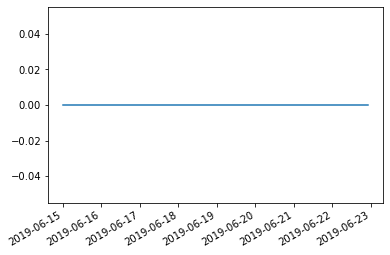

In [270]:
a[a<20].plot()

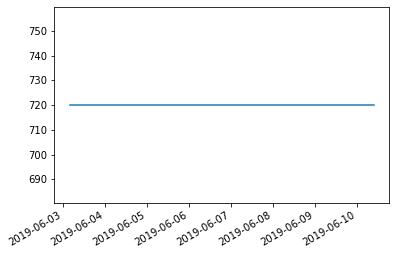

In [106]:
a[a>540].plot()

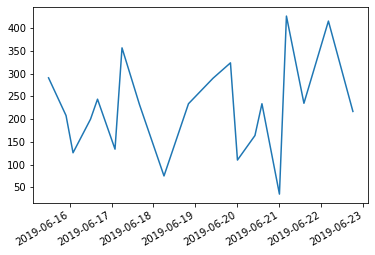

In [212]:
b[a>540].plot()

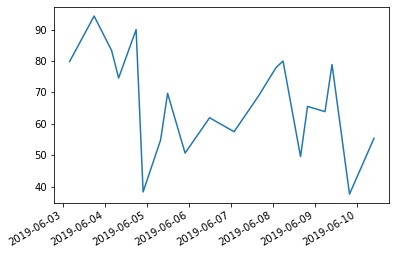

In [108]:
c[a>540].plot()

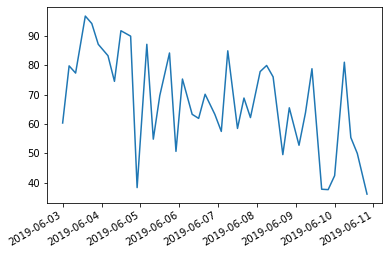

In [110]:
c[a>360].plot()

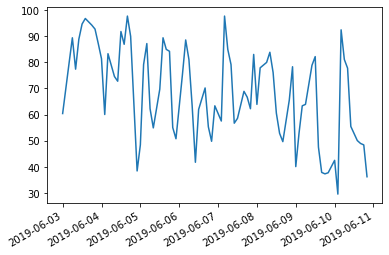

In [111]:
c[a>0].plot()

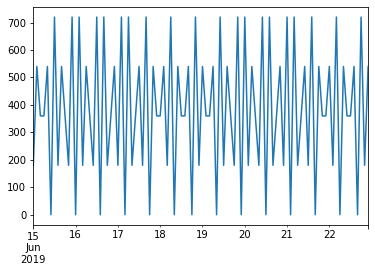

In [346]:
a2H.plot()

In [369]:
a30min

2019-06-15 00:00:00    180.0
2019-06-15 00:30:00      0.0
2019-06-15 01:00:00      0.0
2019-06-15 01:30:00      0.0
2019-06-15 02:00:00      0.0
                       ...  
2019-06-22 21:30:00      0.0
2019-06-22 22:00:00      0.0
2019-06-22 22:30:00    180.0
2019-06-22 23:00:00    180.0
2019-06-22 23:30:00    180.0
Freq: 30T, Name: _SONGBIRD, Length: 384, dtype: float64

In [348]:
x=c2H.copy()
y=c30min.copy()
z=c30min.copy()

x[a2H<550]=pd.NA
y[a30min<20]=pd.NA
z[a30min==0]=pd.NA


In [ ]:
# a count
# b sum
# c freq


In [378]:
# a2H.plot()

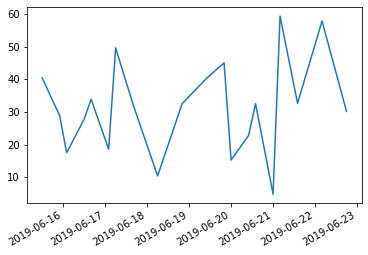

In [349]:
x[False==(x.isnull())].plot()

In [385]:
a2H/

2019-06-15 00:00:00    180.0
2019-06-15 02:00:00    540.0
2019-06-15 04:00:00    360.0
2019-06-15 06:00:00    360.0
2019-06-15 08:00:00    540.0
                       ...  
2019-06-22 14:00:00    540.0
2019-06-22 16:00:00      0.0
2019-06-22 18:00:00    720.0
2019-06-22 20:00:00    180.0
2019-06-22 22:00:00    540.0
Freq: 2H, Name: _SONGBIRD, Length: 96, dtype: float64

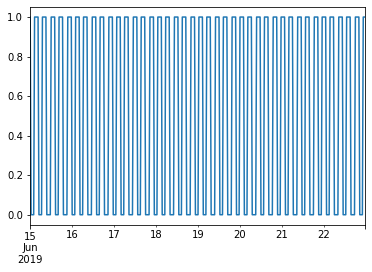

In [389]:
(a30min/180).plot()

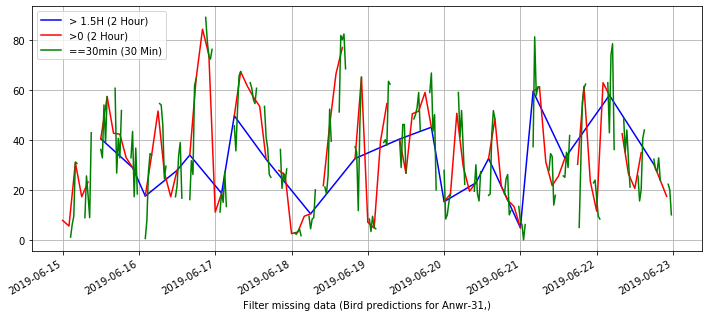

In [373]:
# 30 min
plt.figure(figsize=(12,5)).patch.set_facecolor('white')
plt.xlabel('Filter missing data (Bird predictions for Anwr-31,)')

ax1 = c2H[a2H>550].plot(color='blue', grid=True, label='> 1.5H (2 Hour)')
ax3 = c2H.plot(color='red', grid=True, label='>0 (2 Hour)')
ax2 = y.plot(color='green', grid=True, label='==30min (30 Min)')
# fig.patch.set_facecolor('grey')


h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
h3, l3 = ax3.get_legend_handles_labels()


plt.legend(h1, l1, loc=2)
# plt.show()
plt.savefig("30min-2H-combined")



In [ ]:
# more transparent 
# dalton road 
# start working on that

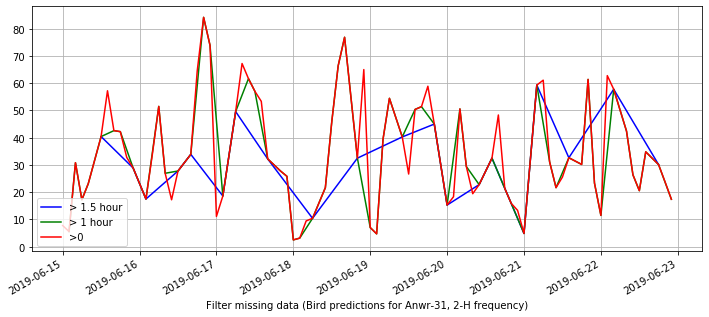

In [305]:
plt.figure(figsize=(12,5)).patch.set_facecolor('white')
plt.xlabel('Filter missing data (Bird predictions for Anwr-31, 2-H frequency)')

ax1 = c2H[a2H>550].plot(color='blue', grid=True, label='> 1.5 hour')
ax2 = c2H[a2H>200].plot(color='green', grid=True, label='> 1 hour')
ax3 = c2H[a2H>0].plot(color='red', grid=True, label='>0')
# fig.patch.set_facecolor('grey')


h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
h3, l3 = ax3.get_legend_handles_labels()


plt.legend(h1, l1, loc=3)
plt.show()

In [243]:
c[a!=-1]

2019-06-15 00:00:00     7.777778
2019-06-15 02:00:00     5.555556
2019-06-15 04:00:00    30.833333
2019-06-15 06:00:00    17.222222
2019-06-15 08:00:00    23.148148
                         ...    
2019-06-22 14:00:00    34.814815
2019-06-22 16:00:00          NaN
2019-06-22 18:00:00    30.138889
2019-06-22 20:00:00    23.888889
2019-06-22 22:00:00    17.407407
Freq: 2H, Name: _SONGBIRD, Length: 96, dtype: float64

In [240]:
c[a>360]

2019-06-15 02:00:00     5.555556
2019-06-15 08:00:00    23.148148
2019-06-15 12:00:00    40.416667
2019-06-15 16:00:00    42.592593
2019-06-15 22:00:00    28.888889
2019-06-16 02:00:00    17.500000
2019-06-16 06:00:00    51.481481
2019-06-16 12:00:00    27.777778
2019-06-16 16:00:00    33.888889
2019-06-16 22:00:00    73.888889
2019-06-17 02:00:00    18.611111
2019-06-17 06:00:00    49.583333
2019-06-17 12:00:00    57.037037
2019-06-17 16:00:00    32.222222
2019-06-17 20:00:00    27.777778
2019-06-18 02:00:00     3.148148
2019-06-18 06:00:00    10.416667
2019-06-18 10:00:00    21.666667
2019-06-18 16:00:00    76.851852
2019-06-18 20:00:00    32.500000
2019-06-19 00:00:00     7.037037
2019-06-19 06:00:00    54.444444
2019-06-19 10:00:00    40.277778
2019-06-19 14:00:00    50.370370
2019-06-19 20:00:00    45.000000
2019-06-20 00:00:00    15.277778
2019-06-20 04:00:00    50.555556
2019-06-20 10:00:00    22.777778
2019-06-20 14:00:00    32.500000
2019-06-20 20:00:00    15.925926
2019-06-21

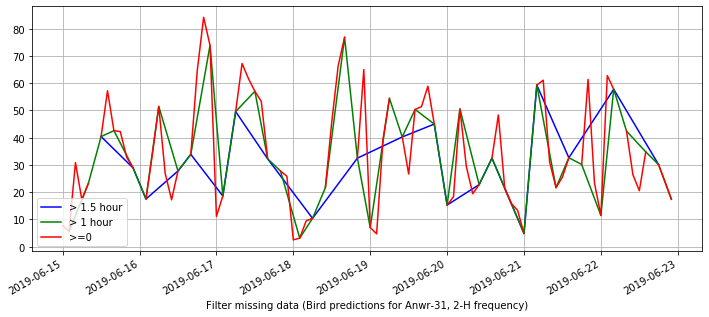

In [255]:
plt.figure(figsize=(12,5)).patch.set_facecolor('white')
plt.xlabel('Filter missing data (Bird predictions for Anwr-31, 2-H frequency)')

ax1 = c[a>550].plot(color='blue', grid=True, label='> 1.5 hour')
ax2 = c[a>530].plot(color='green', grid=True, label='> 1 hour')
ax3 = c[a>-1].plot(color='red', grid=True, label='>=0')


h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
h3, l3 = ax3.get_legend_handles_labels()


plt.legend(h1, l1, loc=3)
# plt.show()
plt.savefig("filterMissingDisconnected")


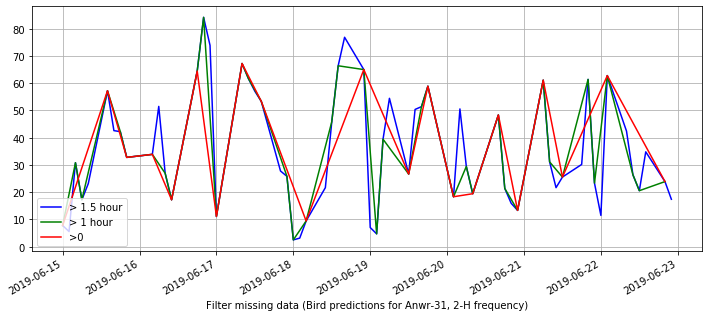

In [224]:
plt.figure(figsize=(12,5))
plt.xlabel('Filter missing data (Bird predictions for Anwr-31, 2-H frequency)')

ax1 = c[a<720].plot(color='blue', grid=True, label='> 1.5 hour')
ax2 = c[a<530].plot(color='green', grid=True, label='> 1 hour')
ax3 = c[a<200].plot(color='red', grid=True, label='>0')


h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
h3, l3 = ax3.get_legend_handles_labels()


plt.legend(h1, l1, loc=3)
plt.show()

In [19]:
no_result_paths

[PosixPath('/tank/data/nna/real/stinchcomb/09-USGS/2016/USGS_20160626_135605.MP3'),
 PosixPath('/tank/data/nna/real/stinchcomb/09-USGS/2016/USGS_20160626_135647.MP3'),
 PosixPath('/tank/data/nna/real/stinchcomb/09-USGS/2016/USGS_20160821_091219.MP3'),
 PosixPath('/tank/data/nna/real/stinchcomb/09-USGS/2016/USGS_20160626_135605.MP3'),
 PosixPath('/tank/data/nna/real/stinchcomb/09-USGS/2016/USGS_20160626_135647.MP3'),
 PosixPath('/tank/data/nna/real/stinchcomb/09-USGS/2016/USGS_20160821_091219.MP3'),
 PosixPath('/tank/data/nna/real/stinchcomb/09-USGS/2016/USGS_20160626_135605.MP3'),
 PosixPath('/tank/data/nna/real/stinchcomb/09-USGS/2016/USGS_20160626_135647.MP3'),
 PosixPath('/tank/data/nna/real/stinchcomb/09-USGS/2016/USGS_20160821_091219.MP3'),
 PosixPath('/tank/data/nna/real/stinchcomb/09-USGS/2016/USGS_20160626_135605.MP3'),
 PosixPath('/tank/data/nna/real/stinchcomb/09-USGS/2016/USGS_20160626_135647.MP3'),
 PosixPath('/tank/data/nna/real/stinchcomb/09-USGS/2016/USGS_20160821_091219

In [20]:
df_count,df_sums=df_dict['09-USGS']

In [21]:
df_sums._SONGBIRD.sum()

305565.0

In [38]:
df_sums._SONGBIRD[df_sums._SONGBIRD>0]

2016-06-03 14:00:00     31.0
2016-06-03 16:00:00     82.0
2016-06-03 18:00:00    625.0
2016-06-03 20:00:00    616.0
2016-06-03 22:00:00    342.0
                       ...  
2016-08-21 00:00:00     69.0
2016-08-21 02:00:00     51.0
2016-08-21 04:00:00     90.0
2016-08-21 06:00:00    203.0
2016-08-21 08:00:00     94.0
Name: _SONGBIRD, Length: 942, dtype: float64

In [23]:
end=datetime(2016, 6, 5, 16, 57, 22)
sum(df_sums._SONGBIRD[:end])

11129.0

In [24]:
firstDay=df_sums._SONGBIRD[:end]/df_count._SONGBIRD[:end]

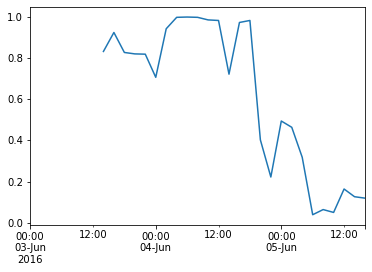

In [25]:
firstDay.plot()

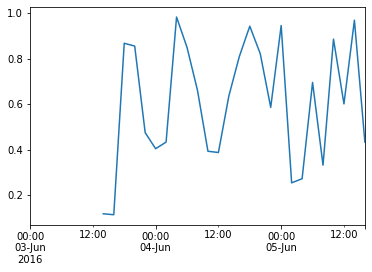

In [54]:
firstDay.plot()

In [35]:
df_sums._SONGBIRD

2016-06-03 00:00:00    0.0
2016-06-03 02:00:00    0.0
2016-06-03 04:00:00    0.0
2016-06-03 06:00:00    0.0
2016-06-03 08:00:00    0.0
                      ... 
2016-08-25 12:00:00    0.0
2016-08-25 14:00:00    0.0
2016-08-25 16:00:00    0.0
2016-08-25 18:00:00    0.0
2016-08-25 20:00:00    0.0
Freq: 2H, Name: _SONGBIRD, Length: 1007, dtype: float64

In [33]:
df_sums.sum()

_AIRCRAFT           946.0
_CABLE           118697.0
_INSECT             656.0
_RAIN              7645.0
_RUNNINGWATER    356091.0
_SONGBIRD        305565.0
_WATERBIRD        62937.0
_WIND            539771.0
dtype: float64

In [147]:
!conda run -n speechEnv python /home/enis/projects/nna/src/slack_message.py -m "figures ready"

In [48]:
uniqueYears=pd.unique([month.year for month in monthsTime])
uniqueYears.size

In [80]:
pd.unique(list(zip(df_freq.index.strftime("%Y-%m"),df_freq.index)))

array([('2018-05', Timestamp('2018-05-08 20:00:00')),
       ('2018-05', Timestamp('2018-05-09 00:00:00')),
       ('2018-05', Timestamp('2018-05-09 02:00:00')), ...,
       ('2019-08', Timestamp('2019-08-27 04:00:00')),
       ('2019-08', Timestamp('2019-08-27 06:00:00')),
       ('2019-08', Timestamp('2019-08-27 08:00:00'))], dtype=object)

In [81]:
uniquMonth=pd.unique(df_freq.index.strftime("%Y-%m-01"))
uniquMonth=[pd.Timestamp(i) for i in uniquMonth]
# monthsTime=[month for month in monthsTime if month.strftime("%Y-%m") in uniquMonth]


[Timestamp('2018-05-01 00:00:00'),
 Timestamp('2018-06-01 00:00:00'),
 Timestamp('2018-07-01 00:00:00'),
 Timestamp('2018-08-01 00:00:00'),
 Timestamp('2019-05-01 00:00:00'),
 Timestamp('2019-06-01 00:00:00'),
 Timestamp('2019-07-01 00:00:00'),
 Timestamp('2019-08-01 00:00:00')]

(12, Int64Index([5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4], dtype='int64'))

In [36]:
monthsTime=pd.date_range("{}-{}".format(all_start.year,all_start.month),"{}-{}".format(all_end.year,all_end.month), freq='MS',)
# monthsTimeStr=["{}-{}".format(month.year,month.month) for month in monthsTime]
# months=[df_freq.loc[month:month] for month in monthsTimeStr]
# months=[month for month in months if month.size>0]

0

In [17]:
def createFigure(months,monthsTime):
    plt.rcParams["axes.prop_cycle"] = get_cycle("tab10",N=8)
    

    fig, ax = plt.subplots(figsize=(80,len(months)*9),nrows=len(months),sharex=True, sharey=True,gridspec_kw={'hspace': 0})
    ax = np.array(ax).reshape(-1) # subplot returns single element for single row

    markers = itertools.cycle((',', '+', '.', 'o', '*')) 

    weather_colors=["firebrick","darkorange","green","seagreen","lightpink"]

    for monthi,month in enumerate(months):
        # for col in df_freq.columns:
        for i,(col,(lat,long)) in enumerate(cord_list):
#             if col in weather_cols:
#                 index=weather_cols.index(col)
#                 ax[monthi].plot_date(month.index.to_pydatetime(), month[col],linestyle="-",marker=" ",color=weather_colors[index])
#             else:
            ax[monthi].plot_date(month.index.to_pydatetime(), month[col],linestyle="-",marker=" ")


    ax[0].legend( labels=[id2name.get(x[0],x[0][1:]) for x in cord_list],loc='upper left', 
                borderpad=0.2, labelspacing=0.2, fontsize=28, 
                frameon=True) # frameon=False to remove frame.




    ax[-1].set_xlabel('Day Number', fontsize=32)

#     uniqueYears=pd.unique([month.year for month in monthsTime])
#     uniqueYears.size
    for i,an_ax in enumerate(ax):
        
        an_ax.set_ylabel('{}'.format(monthsTime[i].strftime("%Y-%B")),fontsize=48) #, fontweight='black')

        locator=dates.DayLocator()
        an_ax.xaxis.set_minor_locator(locator)

        an_ax.xaxis.set_minor_formatter(dates.DateFormatter('%d\n'))

        an_ax.xaxis.grid(True, which="minor")
        an_ax.xaxis.grid(True, which="major")


        an_ax.xaxis.set_major_locator(dates.AutoDateLocator())
        an_ax.xaxis.set_major_formatter(dates.DateFormatter('%d\n'))
        

        an_ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0f}'))
        an_ax.yaxis.grid()
        an_ax.tick_params(labelsize=22,which="minor")
        an_ax.tick_params(labelsize=25,which="major")

    plt.tight_layout()
    plt.margins(x=0)
    plt.subplots_adjust(top=0.90)


    fig.suptitle('Site {}, Normalized Bi-hourly Frequency [%]'.format(selected_area),fontsize=48)
#     plt.show()

    figDir= Path(visFilePath) / ("Freq-"+freq) / regionName 
    figDir.mkdir(parents=True,exist_ok=True)
    figPath= figDir / ("_".join([selected_area,str(year)]) +'.'+"png")
    
    fig.savefig(figPath)
#     fig.savefig("test" +'.png')
    plt.close(fig)


In [59]:
from fileUtils import standardPathStyle,list_files
from visUtils import loadResults

def file2TableDict(selected_areas,model_tag_names,globalindex,globalcolumns,
                    file_properties_df,freq,dataFreq="10S",dataThreshold=0.5,
                    channel=1,gathered_results_perTag=None,
                    result_path=None,fileNameAddon="",prob2binaryFlag=True):
    # using gathered_results_perTag dictionary or  result_path to create
    # a pandas dataframe for visualizations

    # dataFreq is sampling frequency of the data,
    #most of the time we have predictions for each 10 second

    df_dict={key: None for (key) in selected_areas}
    no_result_paths=[]

    #we need to load it from files
    if gathered_results_perTag==None and (result_path==None):
        print("ERROR: gathered_results_perTag or (result_path and subDirectoryAddon )should be defined")
        return (None,None)


    for i,area in enumerate(selected_areas):
        df_sums = pd.DataFrame(index=globalindex, columns=globalcolumns).fillna(0)
        df_count = pd.DataFrame(index=globalindex, columns=globalcolumns).fillna(0)

        for modelTagName in model_tag_names:
            dfRawList=[]
    #         for afile in selected_areas_dict[area]:
            area_filtered=file_properties_df[file_properties_df.site_id==area]
            for afile,row in area_filtered.iterrows():
        #         data=gathered_results[afile][0]
                afile=Path(afile)
                # we either load data from multiple files or from single one
                if gathered_results_perTag==None:
                    # TODO, make _FCmodel variable
                    checkFolder=standardPathStyle(result_path,row,subDirectoryAddon=modelTagName
                                        ,fileNameAddon=fileNameAddon)
                    allSegments = list_files(str(checkFolder)+"/")
                    if not allSegments:
                        data=np.empty(0)
                    else:
                        data=loadResults(allSegments,prob2binaryFlag=prob2binaryFlag,
                                        threshold=dataThreshold,channel=channel)
                        # gathered_results[file]=result[:]
                else:
                    data=gathered_results_perTag[modelTagName].get(afile,np.empty(0))[:]
                    if data.size!=0 and prob2binaryFlag==True:
                        data=prob2binary(data,threshold=0.5,channel=channel)

                if data.size==0:
                    no_result_paths.append(afile)
                    continue

                start=file_properties_df.loc[afile]["timestamp"]
                end =start+timedelta(seconds=(10*(len(data)-1)))
                index = pd.date_range(start,end, freq=dataFreq)
                df_afile=pd.DataFrame(data,index=index,columns=[modelTagName])


                dfRawList.append(df_afile)
            if dfRawList:
                dfRaw=pd.concat(dfRawList)
                dfRaw=dfRaw.sort_index()
                
                df_afile_grouped = dfRaw.groupby([pd.Grouper(freq=freq)])
                counts=df_afile_grouped.count()
                sums=df_afile_grouped.sum()

                df_count=df_count.add(counts, fill_value=0) #df_count.update(counts)
                df_sums=df_sums.add(sums, fill_value=0) #df_sums.update(sums)

            
        df_dict[area]=(df_count.copy(),df_sums.copy())

    return df_dict,no_result_paths


'June'